In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [71]:
from transformers import RobertaForSequenceClassification
from transformers import RobertaTokenizer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import BertForQuestionAnswering

tokenizer_path = "./tokenizer_roberta"
model_path = "./model_roberta"

tokenizer = RobertaTokenizer.from_pretrained(tokenizer_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)

model.to(device)
model.eval()
model.zero_grad()


In [72]:
# Comparaison des chemins des modèles et des tokenizers
print("Model path:", model_path)
print("Tokenizer path:", tokenizer_path)

# Comparaison des vocabulaires des tokenizers
print("Training Tokenizer Vocab Size:", tokenizer.vocab_size)
print("Loaded Tokenizer Vocab Size:", len(tokenizer.get_vocab()))

# Comparaison des paramètres du tokenizer
print("Tokenizer Special Tokens:", tokenizer.special_tokens_map)
print("Tokenizer Max Length:", tokenizer.model_max_length)


Model path: ./model_roberta
Tokenizer path: ./tokenizer_roberta
Training Tokenizer Vocab Size: 50265
Loaded Tokenizer Vocab Size: 50265
Tokenizer Special Tokens: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}
Tokenizer Max Length: 512


In [73]:
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask)
    return output.start_logits, output.end_logits

In [74]:
def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

In [75]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [76]:
def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
        [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    
    return input_embeddings, ref_input_embeddings

In [77]:
question = "i love you so much "
text = ""

In [78]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [79]:
def squad_pos_forward_func2(input_emb, attention_mask=None, position=0):
    pred = model(inputs_embeds=input_emb, attention_mask=attention_mask, )
    pred = pred[position]
    return pred.max(1).values

In [80]:


def construct_whole_roberta_embeddings(input_ids, ref_input_ids, \
                                       token_type_ids=None, ref_token_type_ids=None, \
                                       position_ids=None, ref_position_ids=None):
    input_embeddings = model.roberta.get_input_embeddings()(input_ids)
    ref_input_embeddings = model.roberta.get_input_embeddings()(ref_input_ids)
    
    return input_embeddings, ref_input_embeddings

# Supposons que input_ids, ref_input_ids, token_type_ids, ref_token_type_ids, position_ids, ref_position_ids sont définis
input_embeddings, ref_input_embeddings = construct_whole_roberta_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)


In [81]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [82]:
layer_attrs_start = []
layer_attrs_end = []

# The token that we would like to examine separately.
token_to_explain = 2 # the index of the token that we would like to examine more thoroughly
layer_attrs_start_dist = []
layer_attrs_end_dist = []

for i in range(model.config.num_hidden_layers):
    layer_i = model.roberta.encoder.layer[i]
    lc = LayerConductance(squad_pos_forward_func2, layer_i)
    layer_attributions_start = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask, 0))
    #layer_attributions_end = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask, 1))
    layer_attrs_start.append(summarize_attributions(layer_attributions_start).cpu().detach().tolist())
    #layer_attrs_end.append(summarize_attributions(layer_attributions_end).cpu().detach().tolist())

    # storing attributions of the token id that we would like to examine in more detail in token_to_explain
    layer_attrs_start_dist.append(layer_attributions_start[0,token_to_explain,:].cpu().detach().tolist())
    #layer_attrs_end_dist.append(layer_attributions_end[0,token_to_explain,:].cpu().detach().tolist())

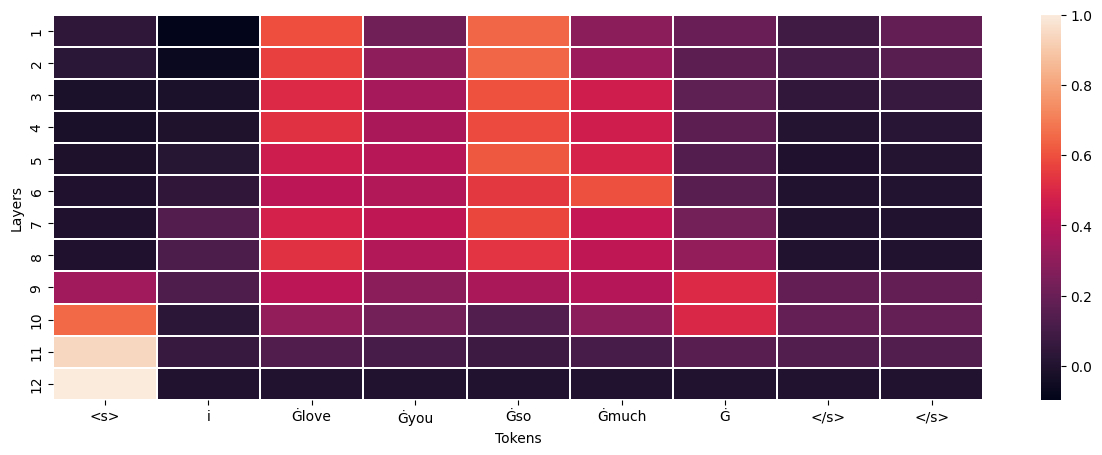

In [83]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs_start), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

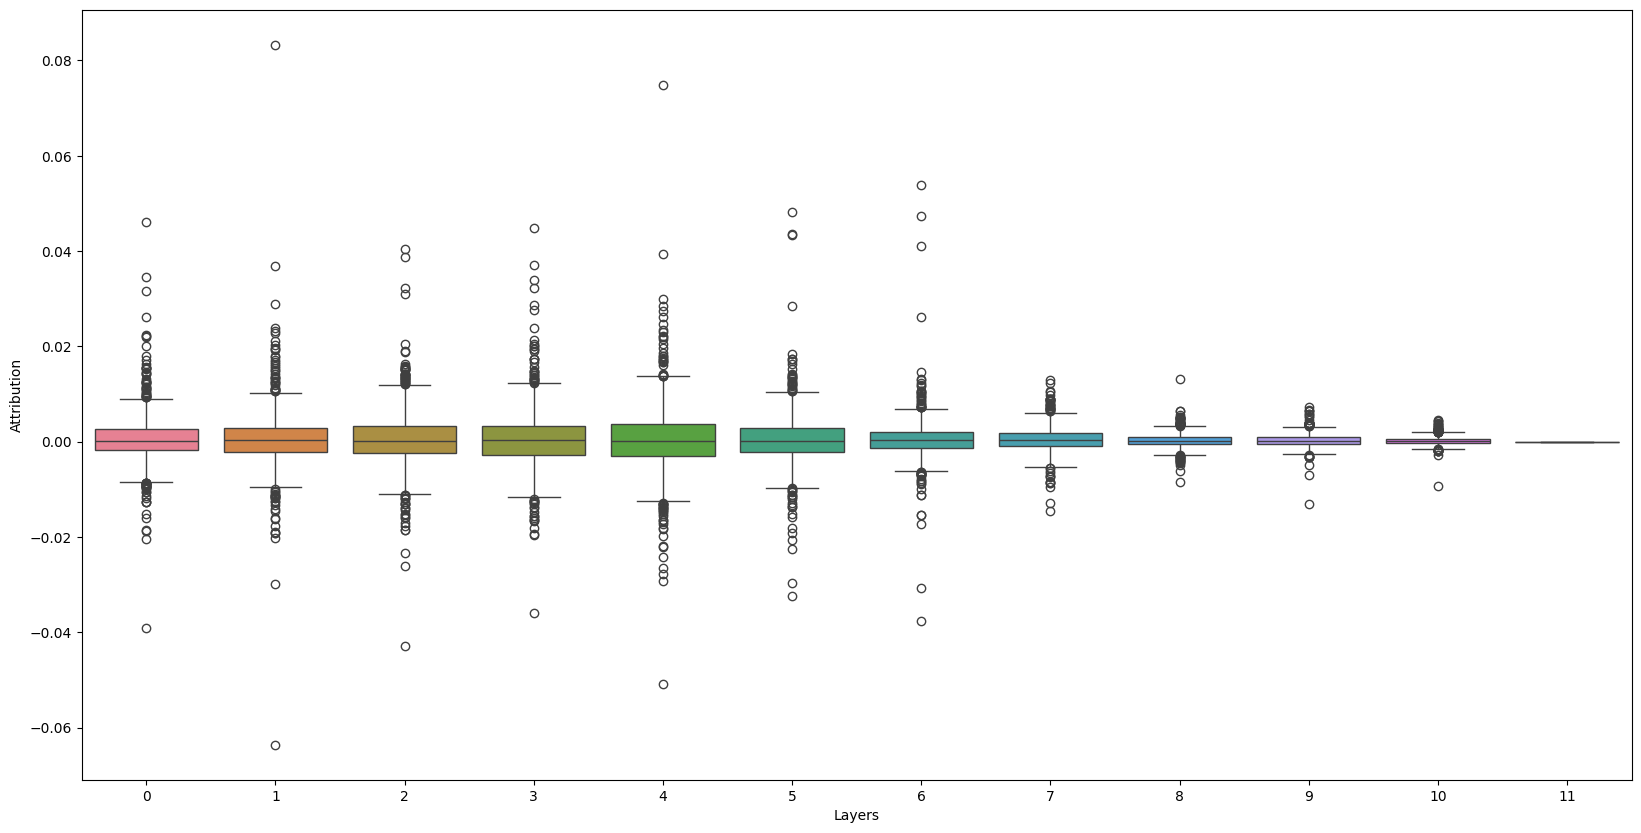

In [84]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_start_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()